<a href="https://colab.research.google.com/github/keith-leung/Celia/blob/master/RobotKinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as tr
import numpy as np
import matplotlib.pyplot as pt

In [ ]:
a = np.arange(2*3).reshape((2,3))
print(a)
a.max(axis=0)

[[0 1 2]
 [3 4 5]]


array([3, 4, 5])

In [ ]:
# Visualize the current arm/gripper position
def viz(arm_points, grip_points, d):
    
    arm_points = arm_points.detach() # for matplotlib
    grip_points = grip_points.detach() # for matplotlib

    # arm_points[0,j], arm_points[1,j] are (x,y) coordinates for joint j
    # similarly the points delineating the gripper
    pt.plot(arm_points[0,:], arm_points[1,:], '-ko')
    pt.plot(grip_points[0,:], grip_points[1,:], '-k')

    pt.xlim([-sum(d), sum(d)])
    pt.ylim([-sum(d), sum(d)])

# Get transformation matrices for position/orientation of each joint
# In transformation matrix M, M[:2,:2] is the rotation and M[:2,3] is the translation
def get_transforms(theta, d):
    # theta[j] is angle for joint j (tr.tensor)
    # d[j] is the length of the link connected to joint j (np.array)
    # theta is tr.tensor so that IK can use gradient descent
    
    # to avoid writing out sin/cos a lot
    s = tr.sin(theta)
    c = tr.cos(theta)
    
    # First transformation (base link) is at the origin, so identity matrix
    # 3x3 for homogenous coordinates
    transforms = [tr.eye(3)]
    
    # Construct remaining transformations for each joint
    for j in range(len(theta)):

        # Translation matrix
        T = tr.tensor([
            [1., 0., d[j]],
            [0., 1., 0.  ],
            [0., 0., 1.  ]])
        # Rotation matrix
        R = tr.eye(3)
        R[0,0] =  c[j]
        R[0,1] = -s[j]
        R[1,0] =  s[j]
        R[1,1] =  c[j]
        # Compose rotation and translation for current joint relative to previous joint
        M = tr.mm(R, T)
        
        # Compose with transforms from previous joints to get relative to origin
        transforms.append(tr.mm(transforms[j], M))

    return transforms

# Forward kinematics: use transforms to get positions of each joint/gripper
def fwd(theta, d):

    # Get transforms for current joints
    transforms = get_transforms(theta, d)

    # Extract coordinates of each joint
    # arm_points[:,j] is cartesian position of j^th joint
    origin = tr.tensor([[0., 0., 1.]]).t()
    arm_points = tr.cat([tr.mm(M, origin) for M in transforms], dim=1)
    
    # Extract points at gripper knuckles and tips
    grip_points = tr.tensor([
        [1.,  1., 1.], # left fingertip
        [0.,  1., 1.], # left knuckle
        [0., -1., 1.], # right knuckle
        [1., -1., 1.], # right fingertip
    ]).t()
    grip_points = tr.mm(transforms[-1], grip_points)
    
    return arm_points, grip_points


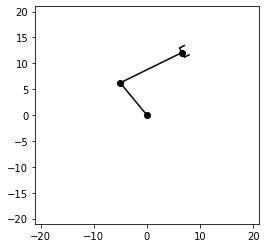

In [ ]:
# Fixed lengths for each link in arm
d = [8., 13.]

# Random joint angles
theta = tr.rand(len(d)) * np.pi * 2

# # Hand-chosen joint angles
#theta = tr.tensor([0, np.pi/2])
theta = tr.tensor([2.25, 4.5])

# Forward kinematics
arm_points, grip_points = fwd(theta, d)

# Visualize current arm position
pt.figure(figsize=(4,4))
viz(arm_points, grip_points, d)


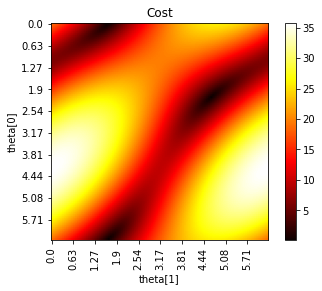

In [ ]:
# Fixed lengths for each link in arm
d = [8., 13.]
target = tr.tensor([[7., 13., 1.]]).t()

angles = tr.linspace(0, np.pi*2, 100)
cost = tr.zeros(len(angles), len(angles))
for i in range(len(angles)):
  for j in range(len(angles)):
    theta = angles[[i, j]]
    arm_points, grip_points = fwd(theta, d)
    cost[i,j] = ((arm_points[:,[-1]] - target)**2).sum()**.5

pt.imshow(cost, cmap='hot')
pt.xticks(np.arange(len(angles))[::10], angles.numpy().round(2)[::10], rotation=90)
pt.xlabel("theta[1]")
pt.yticks(np.arange(len(angles))[::10], angles.numpy().round(2)[::10])
pt.ylabel("theta[0]")
pt.title("Cost")
pt.colorbar()
pt.show()

In [ ]:
# Automatic differentiation examples

def g(x):
  y = x**2
  return y
def f(y):
  z = 3*y
  return z

# 3x**2 -> 6*x

x = tr.tensor(1., requires_grad=True)

# is this gradient correct?
f(g(x)).backward()
print(x.grad)

# pytorch accumulates gradients
f(g(x)).backward()
print(x.grad)

f(g(x)).backward()
print(x.grad)

# so explicitly zero the gradient if you need to start fresh
x.grad *= 0
f(g(x)).backward()
print(x.grad)

# array operations are also differentiated seamlessly
x = tr.tensor([1., 0., -1.], requires_grad=True)

print(f(g(x)))
print(f(g(x)).sum())


f(g(x)).sum().backward()
print(x.grad)

tensor(6.)
tensor(12.)
tensor(18.)
tensor(6.)
tensor([3., 0., 3.], grad_fn=<MulBackward0>)
tensor(6., grad_fn=<SumBackward0>)
tensor([ 6.,  0., -6.])


In [ ]:
def f(x, y):
  h = 3*x + 2*y
  return h
def g(h):
  return (h**2).sum()

# TODO: modify to enable gradient calculations
x = tr.tensor([1., 0.], requires_grad=True)
y = tr.tensor([0., 1.], requires_grad=True)
h = f(x, y)
z = g(h)

print("z:")
print(z)
print("h:")
print(h)

z.backward()

print("x.grad:")
print(x.grad)
print("y.grad:")
print(y.grad)


z:
tensor(13., grad_fn=<SumBackward0>)
h:
tensor([3., 2.], grad_fn=<AddBackward0>)
x.grad:
tensor([18., 12.])
y.grad:
tensor([12.,  8.])


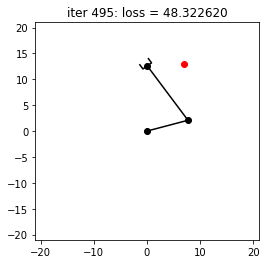

In [ ]:
from IPython import display # used for animation

fig = pt.figure(figsize=(4,4)) # each time-step is rendered on this figure

# Fixed lengths for each link in arm
# d = [3.5, 3.0, 2.5]
d = [8., 13.]

# Start joint angles at zero
# Require gradient since joints will be optimized
theta = tr.zeros(len(d), requires_grad=True)

# Example target position for gripper in homogenous coordinates
#target = tr.tensor([[3., 8., 1.]]).t()
target = tr.tensor([[7., 13., 1.]]).t()

# Keep track of theta during descent
history = []

# Visualize IK
# 500 iterations of gradient descent
# "loss" is squared distance between gripper and target
# taking gradient of loss w.r.t joint angles
for t in range(500):

    # Save current angles in history
    history.append(theta.clone().detach().numpy())

    # Forward kinematics for current arm position
    arm_points, grip_points = fwd(theta, d)

    # Gradient descent
    loss = ((arm_points[:,[-1]] - target)**2).sum()
    loss.backward()
    theta.data -= 0.003 * theta.grad # 0.0001 learning rate
    theta.grad *= 0 # zero-out for next backward call

    if t % 5 == 0:
      # Visualize current arm position and error
      pt.cla()
      pt.plot(target[0,0], target[1,0], 'ro')
      viz(arm_points, grip_points, d)
      pt.title("iter %d: loss = %f" % (t, loss))

      # Boiler-plate code for the animation
      display.display(fig) # Display the current figure content
      display.clear_output(wait=True) # don't clear it until new content is ready



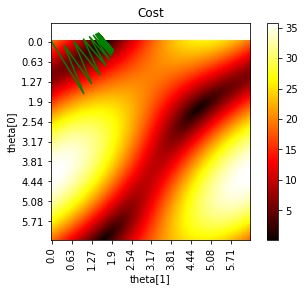

In [ ]:
# Visualize history of theta estimates in the cost landscape

# Convert thetas to grid coordinates
coords = np.stack(history) # stack into one big array
coords = 100 * coords / (2*np.pi)
t0, t1 = coords[:,0], coords[:,1]

pt.imshow(cost, cmap='hot')
pt.plot(t1, t0, 'g-')
pt.xticks(np.arange(len(angles))[::10], angles.numpy().round(2)[::10], rotation=90)
pt.xlabel("theta[1]")
pt.yticks(np.arange(len(angles))[::10], angles.numpy().round(2)[::10])
pt.ylabel("theta[0]")
pt.title("Cost")
pt.colorbar()
pt.show()